# Beta Hedging
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie with example algorithms by David Edwards

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

## Factor Models

Factor models are a way of explaining the returns of one asset via a linear combination of the returns of other assets. The general form of a factor model is

$$Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n$$

This looks familiar, as it is exactly the model type that a linear regression fits. The $X$'s can also be indicators rather than assets. An example might be a analyst estimation.

## What is Beta?

An asset's beta to another asset is just the $\beta$ from the above model. For instance, if we regressed TSLA against the S&P 500 using the model $Y_{TSLA} = \alpha + \beta X$, then TSLA's beta exposure to the S&P 500 would be that beta. If we used the model $Y_{TSLA} = \alpha + \beta X_{SPY} + \beta X_{AAPL}$, then we now have two betas, one is TSLA's exposure to the S&P 500 and one is TSLA's exposure to AAPL.

Often "beta" will refer to a stock's beta exposure to the S&P 500. We will use it to mean that unless otherwise specified.

In [3]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import zipline

In [4]:
# Get data for the specified period and stocks
start = '2014-01-01'
end = '2015-01-01'
asset = zipline.get_pricing('TSLA', fields='price', start_date=start, end_date=end)
benchmark = zipline.get_pricing('SPY', fields='price', start_date=start, end_date=end)

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

# Let's plot them just for fun
r_a.plot()
r_b.plot()
plt.ylabel("Daily Return")
plt.legend();

AttributeError: module 'zipline' has no attribute 'get_pricing'

Now we can perform the regression to find $\alpha$ and $\beta$:

In [3]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: 0.000933400478154
beta: 1.92533467685


If we plot the line $\alpha + \beta X$, we can see that it does indeed look like the line of best fit:

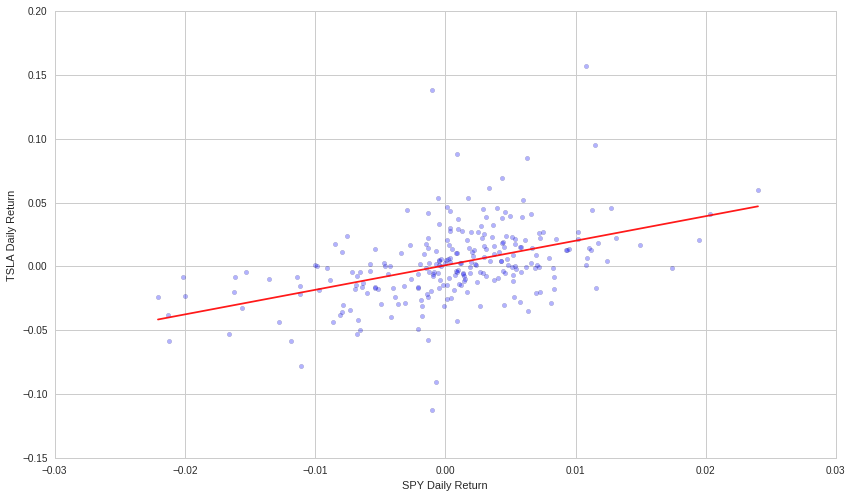

In [4]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("TSLA Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9);

##Risk Exposure

More generally, this beta gets at the concept of how much risk exposure you take on by holding an asset. If an asset has a high beta exposure to the S&P 500, then while it will do very well while the market is rising, it will do very poorly when the market falls. A high beta corresponds to high speculative risk. You are taking out a more volatile bet.

At Quantopian, we value stratgies that have negligible beta exposure to as many factors as possible. What this means is that all of the returns in a strategy lie in the $\alpha$ portion of the model, and are independent of other factors. This is highly desirable, as it means that the strategy is agnostic to market conditions. It will make money equally well in a crash as it will during a bull market. These strategies are the most attractive to individuals with huge cash pools such as endowments and soverign wealth funds.

##Risk Management

The process of reducing exposure to other factors is known as risk management. Hedging is one of the best ways to perform risk management in practice.

###Hedging

If we determine that our portfolio's returns are dependent on the market via this relation

$$Y_{portfolio} = \alpha + \beta X_{SPY}$$

then we can take out a short position in SPY to try to cancel out this risk. The amount we take out is $-\beta V$ where $V$ is the total value of our portfolio. This works because if our returns are approximated by $\alpha + \beta X_{SPY}$, then adding a short in SPY will make our new returns be $\alpha + \beta X_{SPY} - \beta X_{SPY} = \alpha$. Our returns are now purely alpha, which is independent of SPY and will suffer no risk exposure to the market.

###Market Neutral

When a stragy exhibits a consistent beta of 0, we say that this strategy is market neutral.

###Problems with Estimation

The problem here is that the beta we estimated is not necessarily going to stay the same as we walk forward in time. As such the amount of short we took out in the SPY may not perfectly hedge our portfolio, and in practice it is quite difficult to reduce beta by a significant amount.

We will talk more about problems with estimating parameters in future lectures. In short, each estimate has a stardard error that corresponds with how stable the estimate is within the observed data.

# Implementing hedging

Now that we know how much to hedge, let's see how it affects our returns. We will build our portfolio using the asset and the benchmark, weighing the benchmark by $-\beta$ (negative since we are short in it).

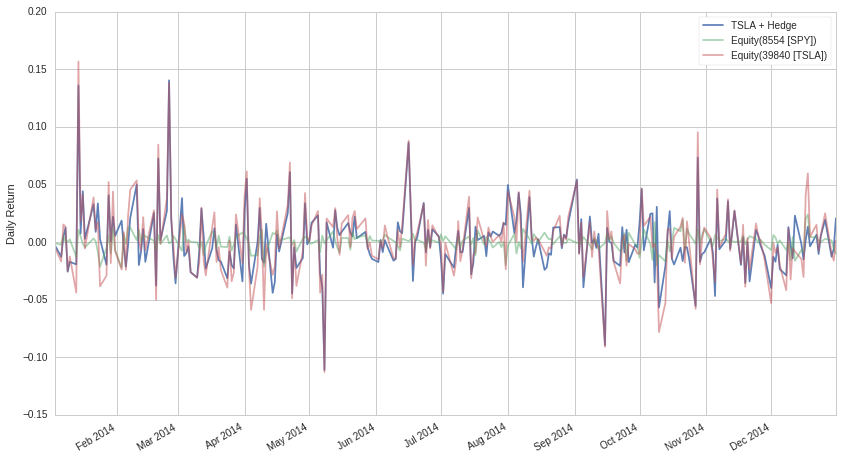

In [5]:
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_b + r_a
portfolio.name = "TSLA + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.5);
r_a.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();

It looks like the portfolio return follows the asset alone fairly closely. We can quantify the difference in their performances by computing the mean returns and the volatilities (standard deviations of returns) for both:

In [6]:
print "means: ", portfolio.mean(), r_a.mean()
print "volatilities: ", portfolio.std(), r_a.std()

means:  0.000933400478154 0.00202306495086
volatilities:  0.0272706740464 0.0304951089833


We've decreased volatility at the expense of some returns. Let's check that the alpha is the same as before, while the beta has been eliminated:

In [7]:
P = portfolio.values
alpha, beta = linreg(X,P)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: 0.000933400478154
beta: 5.10008701937e-16


Note that we developed our hedging strategy using historical data. We can check that it is still valid out of sample by checking the alpha and beta values of the asset and the hedged portfolio in a different time frame:

Asset Historical Estimate:
alpha: 0.000933400478154
beta: 1.92533467685
Asset Out of Sample Estimate:
alpha: 0.00110649636847
beta: 1.04387060693
Portfolio Out of Sample:
alpha: 0.00110649636847
beta: -0.881464069921


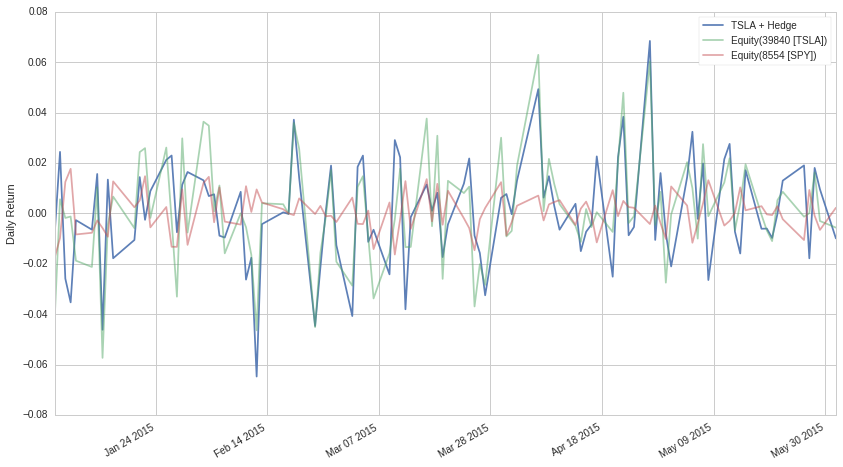

In [8]:
# Get the alpha and beta estimates over the last year
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('TSLA', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
historical_alpha, historical_beta = linreg(X,Y)
print 'Asset Historical Estimate:'
print 'alpha: ' + str(historical_alpha)
print 'beta: ' + str(historical_beta)

# Get data for a different time frame:
start = '2015-01-01'
end = '2015-06-01'
asset = get_pricing('TSLA', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# Repeat the process from before to compute alpha and beta for the asset
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
alpha, beta = linreg(X,Y)
print 'Asset Out of Sample Estimate:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

# Create hedged portfolio and compute alpha and beta
portfolio = -1*historical_beta*r_b + r_a
P = portfolio.values
alpha, beta = linreg(X,P)
print 'Portfolio Out of Sample:'
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)


# Plot the returns of the portfolio as well as the asset by itself
portfolio.name = "TSLA + Hedge"
portfolio.plot(alpha=0.9)
r_a.plot(alpha=0.5);
r_b.plot(alpha=0.5)
plt.ylabel("Daily Return")
plt.legend();

As we can see, the beta estimate changes a good deal when we look at the out of sample estimate. The beta that we computed over our historical data doesn't do a great job at reducing the beta of our portfolio, but does manage to reduce the magnitude by about 1/2.

##The alpha/beta Tradeoff

Hedging against a benchmark such as the market will indeed reduce your returns while the market is not doing poorly. This is, however, completely fine. If your algorithm is less volatile, you will be able to take out leverage on your strategy and multiply your returns back up to their original amount. Even better, your returns will be far more stable than the original volatile beta exposed strategy.

By and large, even though high-beta strategies tend to be deceptively attractive due to their extremely good returns during periods of market growth, they fail in the long term as they will suffer extreme losses during a downturn.

#Other types of hedging

Although we will not execute them here, there are strategies for hedging that may be better suited for other investment approaches.

##Pairs Trading

One is pairs trading, in which a second asset is used in place of the benchmark here. This would allow you, for instance, to cancel out the volatility in an industry by being long in the stock of one company and short in the stock of another company in the same industry.

[www.quantopian.com/lectures](https://www.quantopian.com/lectures)

##Long Short Equity

In this case we define a ranking over a group of $n$ equities, then long the top $p\%$ and short the bottom $p\%$ in equal dollar volume. This has the advantage of being implicitly, versus explicitly, hedged when $n$ is large. To see why this is the case, imagine buying a set of 100 securities randomly. The chance that the market exposure beta of these 100 is far from 1.0 is very low, as we have taken a large sample of the market. Similarly, when we rank by some independent metric and buy the top 100, the chance that we select securities whose overall beta is far from 1.0 is low. So in selecting 100 long and 100 short, the strategy beta should be very close to 1 - 1 = 0. Obviously some ranking systems will introduce a sample bias and break this assumption, for example ranking by the estimated beta of the equity.

Another advantage of long short equity strategies is that you are making a bet on the ranking, or in other words the differential in performance between the top and bottom ranked equities. This means that you don't have to even worry about the alpha/beta tradeoff encountered in hedging.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*